In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download('https://www.kaggle.com/datasets/mssmartypants/rice-type-classification')

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
data_df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
data_df

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18180,18181,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,18182,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,18183,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,18184,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [ ]:
data_df.dropna(inplace=True)
data_df.drop(['id'],axis=1,inplace=True)

In [ ]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
print(data_df['Class'].unique())

[1 0]


In [ ]:
data_df['Class'].value_counts()

,count
Class,
1,9985
0,8200


In [ ]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()

data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [ ]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1])

In [ ]:
X.shape

(18185, 10)

In [ ]:
Y.shape

(18185,)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3)

In [ ]:
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [ ]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = torch.tensor(X,dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y,dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index],self.Y[index]

In [ ]:
training_data = dataset(X_train,y_train)
validation_data = dataset(X_val,y_val)
testing_data = dataset(X_test,y_test)

In [ ]:
train_dataloader = DataLoader(training_data,batch_size=8,shuffle=True)
validation_dataloader = DataLoader(validation_data,batch_size=8,shuffle=True)
testing_dataloader = DataLoader(testing_data,batch_size=8,shuffle=True)

In [ ]:
for x,y in train_dataloader:
  print(x)
  print('======')
  print(y)
  break

tensor([[0.8973, 0.8718, 0.8928, 0.9177, 0.8539, 0.9472, 0.6649, 0.7493, 0.8765,
         0.5540],
        [0.6452, 0.6572, 0.8706, 0.8299, 0.6097, 0.8033, 0.9702, 0.6211, 0.9173,
         0.4283],
        [0.5689, 0.8108, 0.6165, 0.9718, 0.5426, 0.7542, 0.7510, 0.6564, 0.7241,
         0.7461],
        [0.8414, 0.8334, 0.8821, 0.9092, 0.7989, 0.9173, 0.7975, 0.7262, 0.8749,
         0.5360],
        [0.9065, 0.8806, 0.8917, 0.9204, 0.8659, 0.9521, 0.7326, 0.8196, 0.7401,
         0.5603],
        [0.6210, 0.8664, 0.6229, 0.9786, 0.5892, 0.7880, 0.8931, 0.6863, 0.7231,
         0.7890],
        [0.6497, 0.9248, 0.6135, 0.9871, 0.6215, 0.8060, 0.5165, 0.7234, 0.6808,
         0.8552],
        [0.7003, 0.9193, 0.6681, 0.9773, 0.6801, 0.8368, 0.7276, 0.7699, 0.6479,
         0.7807]])
tensor([0., 0., 1., 0., 0., 1., 1., 1.])


In [ ]:
HIDDEN_NEURONS = 10
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel , self).__init__()

    self.input_layer = nn.Linear(X.shape[1],HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmoid = nn.Sigmoid()
  def forward(self,x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

In [ ]:
model

MyModel(
  (input_layer): Linear(in_features=10, out_features=10, bias=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=1e-3)


In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 30

for epoch in range(epochs):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:
    inputs,labels = data
    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction,labels)

    total_loss_train += batch_loss.item()
    # print(prediction) #tensor([0.6412, 0.6376, 0.6495, 0.6432, 0.6484, 0.6459, 0.6364, 0.6583],grad_fn=<SqueezeBackward1>)
    acc = ((prediction).round() == labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:
      inputs,labels = data

      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction,labels)

      total_loss_val += batch_loss.item()
      acc = ((prediction).round()== labels).sum().item()

      total_acc_val += acc
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100,4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__() * 100,4))

  print(f'''Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000,4)} , Train Accuracy {round(total_acc_train/training_data.__len__() * 100,4)}
            Validation Loss : {round(total_loss_val/1000,4)} Validataion Accuracy {round(total_acc_val/validation_data.__len__() * 100,4)}
        ''')

Epoch no. 1 Train Loss: 0.0688 , Train Accuracy 98.5545
            Validation Loss : 0.0103 Validataion Accuracy 99.1935
        
Epoch no. 2 Train Loss: 0.0687 , Train Accuracy 98.6016
            Validation Loss : 0.0104 Validataion Accuracy 99.0836
        
Epoch no. 3 Train Loss: 0.0681 , Train Accuracy 98.5702
            Validation Loss : 0.0116 Validataion Accuracy 98.717
        
Epoch no. 4 Train Loss: 0.067 , Train Accuracy 98.5859
            Validation Loss : 0.0128 Validataion Accuracy 98.5704
        
Epoch no. 5 Train Loss: 0.0686 , Train Accuracy 98.5466
            Validation Loss : 0.0102 Validataion Accuracy 99.1569
        
Epoch no. 6 Train Loss: 0.0679 , Train Accuracy 98.5545
            Validation Loss : 0.0107 Validataion Accuracy 99.0836
        
Epoch no. 7 Train Loss: 0.0684 , Train Accuracy 98.5309
            Validation Loss : 0.0108 Validataion Accuracy 99.0836
        
Epoch no. 8 Train Loss: 0.0682 , Train Accuracy 98.5073
            Validation Loss :

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs , labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion(prediction,labels).item()
    total_loss_test += batch_loss_test

    acc = ((prediction).round() == labels).sum().item()

    total_acc_test += acc

print(total_acc_test)
print(testing_data.__len__())
print("Accuracy :",round(total_acc_test/testing_data.__len__() * 100,4))

2683
2728
Accuracy : 98.3504


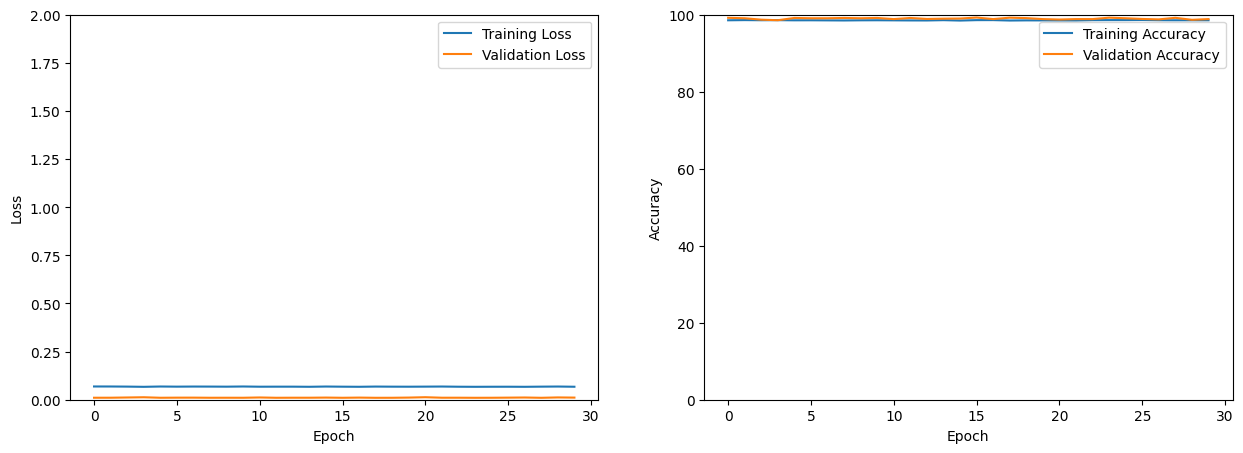

In [ ]:
fig, axs = plt.subplots(nrows= 1 , ncols=2,figsize = (15,5))

axs[0].plot(total_loss_train_plot,label = 'Training Loss')
axs[0].plot(total_loss_validation_plot,label = 'Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label = 'Training Accuracy')
axs[1].plot(total_acc_validation_plot,label = 'Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [ ]:
original_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...
18180,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [ ]:
area = 2353/original_df['Area'].abs().max()

MajorAxisLength = 81/original_df['MajorAxisLength'].abs().max()

MinorAxisLength = 42/original_df['MinorAxisLength'].abs().max()

Eccentricity = 12/original_df['Eccentricity'].abs().max()

ConvexArea = 12/original_df['ConvexArea'].abs().max()

EquivDiameter = 33/original_df['EquivDiameter'].abs().max()

Extent = 98/original_df['Extent'].abs().max()

Perimeter = 972/original_df['Perimeter'].abs().max()

Roundness = 677/original_df['Roundness'].abs().max()

AspectRation = 22/original_df['AspectRation'].abs().max()

myprediction = model(torch.tensor([area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation] , dtype = torch.float32).to(device))

In [ ]:
round(myprediction.item())

0